# La Liga Data Analysis

## Package Requirements & Database

In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from tabulate import tabulate
import openpyxl
import seaborn as sns

In [4]:
with sqlite3.connect("../laliga.sqlite") as con:
    df=pd.read_sql_query("SELECT * FROM Matches",con)
    dr=pd.read_sql_query("SELECT * FROM Predictions",con)

## Exercises

### Exercise 1
**Is it true that the home team is more likely to win? Make a pie chart showing the result distribution (whether home team wins, visitor team wins, or there’s a tie) of all matches in the data. Write in the plot the percentage of each category.**

As can be seen in the pie chart below, it is indeed true that it is more likely for the home team to win, with a 52.8% chance.

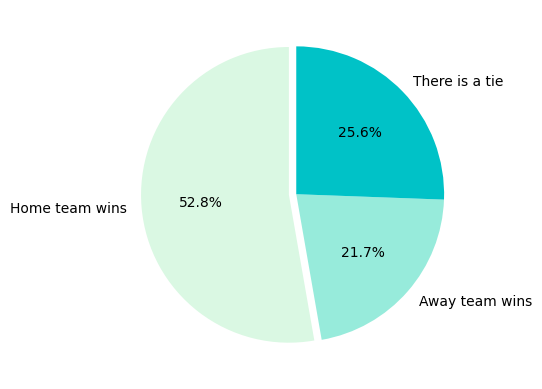

In [5]:
df = df.dropna(subset=['score'])

df["score_home_team"] = df["score"].str.split(":").str[0].astype(float)
df["score_away_team"] = df["score"].str.split(":").str[1].astype(float)

home_wins = (df['score_home_team'] > df['score_away_team']).sum()
away_wins = (df['score_home_team'] < df['score_away_team']).sum()
ties = (df['score_home_team'] == df['score_away_team']).sum()

sizes = [home_wins, away_wins, ties]
labels = ['Home team wins', 'Away team wins', 'There is a tie']
explode = (0.05, 0.0, 0.0)
colors = ['#daf8e3', '#97ebdb', '#00c2c7']

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)

plt.show()

### Exercise 2

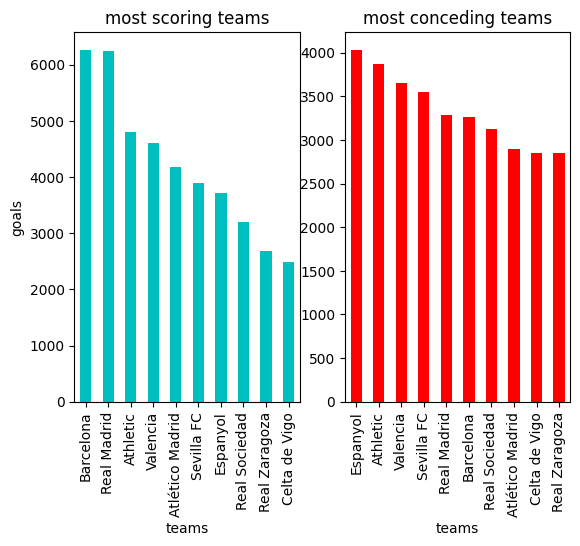

C:\Users\usuario\AppData\Local\Temp\ipykernel_16632\1951742025.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_division['score_difference'] = np.abs(df_first_division["score_home_team"] - df_first_division["score_away_team"])
C:\Users\usuario\AppData\Local\Temp\ipykernel_16632\1951742025.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_division['game_name'] = df_first_division["home_team"] + ' vs ' + df_first_division["away_team"]


In [6]:
df_first_division = df[df['division'] == 1]

goals_scored = df_first_division.groupby('home_team')['score_home_team'].sum() + df_first_division.groupby('away_team')['score_away_team'].sum()
top_scorers = goals_scored.sort_values(ascending=False).head(10)

goals_conceded = df_first_division.groupby('home_team')['score_away_team'].sum() + df_first_division.groupby('away_team')['score_home_team'].sum()
top_conceders = goals_conceded.sort_values(ascending=False).head(10)

plt.subplot(1, 2, 1)
top_scorers.plot(x='nombre', y='valor', kind='bar',color='c')
plt.xlabel('teams')
plt.ylabel('goals')
plt.title('most scoring teams')

plt.subplot(1, 2, 2)
top_conceders.plot(x='nombre', y='valor', kind='bar',color='r')
plt.xlabel('teams')
plt.title('most conceding teams')
plt.show()

df_first_division['score_difference'] = np.abs(df_first_division["score_home_team"] - df_first_division["score_away_team"])
df_first_division['game_name'] = df_first_division["home_team"] + ' vs ' + df_first_division["away_team"]
differences= df_first_division.iloc[:,-2:].sort_values(by='score_difference',ascending=False).head(10)

#table = tabulate(differences, headers='keys', tablefmt='pretty', showindex=False)
#print(table)



### Exercise 3

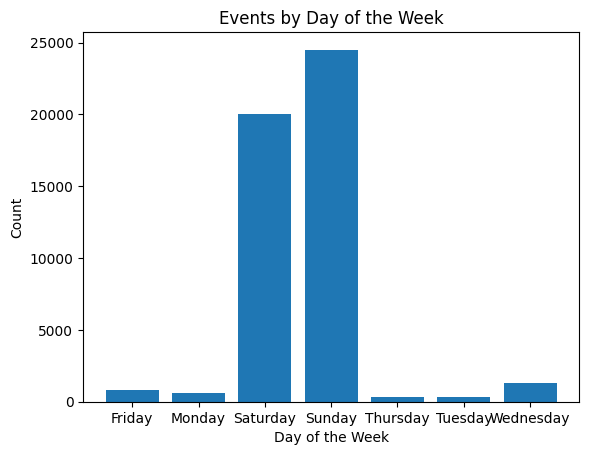

In [7]:
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
df['Day_of_Week'] = df['date'].dt.day_name()

day_of_week_counts = df['Day_of_Week'].value_counts().sort_index()

plt.bar(day_of_week_counts.index, day_of_week_counts)
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Events by Day of the Week')
plt.show()

### Exercise 4

#### Build a cross results table for season 2020-2021 (1st division). 

The code below, when executed, displays a cross table in which if the home team wins the background is color green, if the away team wins the background color is red and if there is a tie the background color is orange. 

In [8]:
#here we are creating a data frame with the results from the first division in season 2020-2021
df_season20_21=df_first_division[df_first_division['season']=='2020-2021'] 
#creation of the table
table=df_season20_21.pivot(index='home_team', columns='away_team',values='score')
table=table.fillna('-')

#function for coloring the table according to who wins de match
def coloring(value):
    if value=='-':
        return '' #the values of the table with '-' don't get coloured!!
    else:
        parts=value.split(":") #we are extracting the ':' in order to be able to compare scores!!!
        home_score=int(parts[0])
        away_score=int(parts[1])  
        if home_score>away_score:
            return 'background-color: rgba(144, 238, 144,0.55)'
        if home_score<away_score:
            return 'background-color: rgba(255, 37, 44,0.7)'
        if home_score==away_score:
            return 'background-color:rgb(255,179,71); color:black'
    
colored_table=table.style.map(coloring) 
display(colored_table)

away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,-,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,-,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,-,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,-,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,-,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,-,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,-,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,-,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3


#### Could you model the intensity of this background color with the goal difference from the match?

The code below does the same as the one in the cell above, but now we asign a difference intensity of the code according to the value of the difference between the score of the home team and the away team: as more different are the scores, the brighter the color gets.

In [9]:
df_season20_21=df_first_division[df_first_division['season']=='2020-2021']
table=df_season20_21.pivot(index='home_team', columns='away_team',values='score')
table=table.fillna('-')
#here we are calculating the maximum diference between scores that there is when the home team wins and when the away team wins
max_dif_homewins=(df_season20_21['score_home_team']-df_season20_21['score_away_team']).max()
max_dif_awaywins=(-df_season20_21['score_home_team']+df_season20_21['score_away_team']).max()

#function for coloring, now with gradients :)
def coloring_gradients(value):
    if value=='-':
        return '' 
    else:
        parts=value.split(":")
        home_score=float(parts[0])
        away_score=float(parts[1])
        if home_score>away_score:
            alpha=(home_score-away_score)/max_dif_homewins #this is the transparency that the cell acquires, as more difference, the less transparency there is
            if alpha>=0.8:
                return f'background-color:rgba(144, 238, 144, {alpha});color:black' #so the letters can be read!!!
            else:
                return f'background-color:rgba(144, 238, 144, {alpha});color:white'  
        if home_score<away_score:
            alpha=(-home_score+away_score)/max_dif_awaywins
            return f'background-color:rgba(255, 37, 44, {alpha})'
        if home_score==away_score:
            return 'background-color:rgb(255,179,71); color:black'
    
colored_table=table.style.map(coloring_gradients)

display(colored_table)

away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,-,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,-,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,-,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,-,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,-,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,-,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,-,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,-,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3


#### Write a function that, given the season ant the division, plots the cross section results table

Since we have two types of table created, we have two functions according to the type of colors you want (if you want the gradient or not).

Table without the gradient:

In [10]:
def table_for_any_season(x,y):
    df_unknown_div= df[df['division']==x]
    df_any_season=df_unknown_div[df_unknown_div['season']==y]
    table_any_seas=df_any_season.pivot_table(index='home_team', columns='away_team',values='score',aggfunc=list,fill_value='-',margins=False)
    table_any_seas=table.fillna('-')
    colored_table=table_any_seas.style.map(coloring) 
    return colored_table
#If you want to try the function with more values make sure to put first the number of the division (1 or 2) and the season with format 'year-year'
display(table_for_any_season(1,'2013-2012')) 

away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,-,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,-,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,-,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,-,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,-,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,-,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,-,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,-,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3


Table with the gradient:

In [11]:
def table_for_any_season_with_gradient(x,y):
    df_unknown_div= df[df['division']==x]
    df_any_season=df_unknown_div[df_unknown_div['season']==y]
    table_any_seas=df_any_season.pivot_table(index='home_team', columns='away_team',values='score',aggfunc=list,fill_value='-',margins=False)
    table_any_seas=table.fillna('-')
    colored_table_gradient=table_any_seas.style.map(coloring_gradients) 
    return colored_table_gradient
#same recquirements as before, first write the function (1 or 2) and then the season as 'year-year'
display(table_for_any_season_with_gradient(2,'2001-2000'))


away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,-,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,-,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,-,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,-,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,-,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,-,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,-,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,-,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3


### Exercise 5

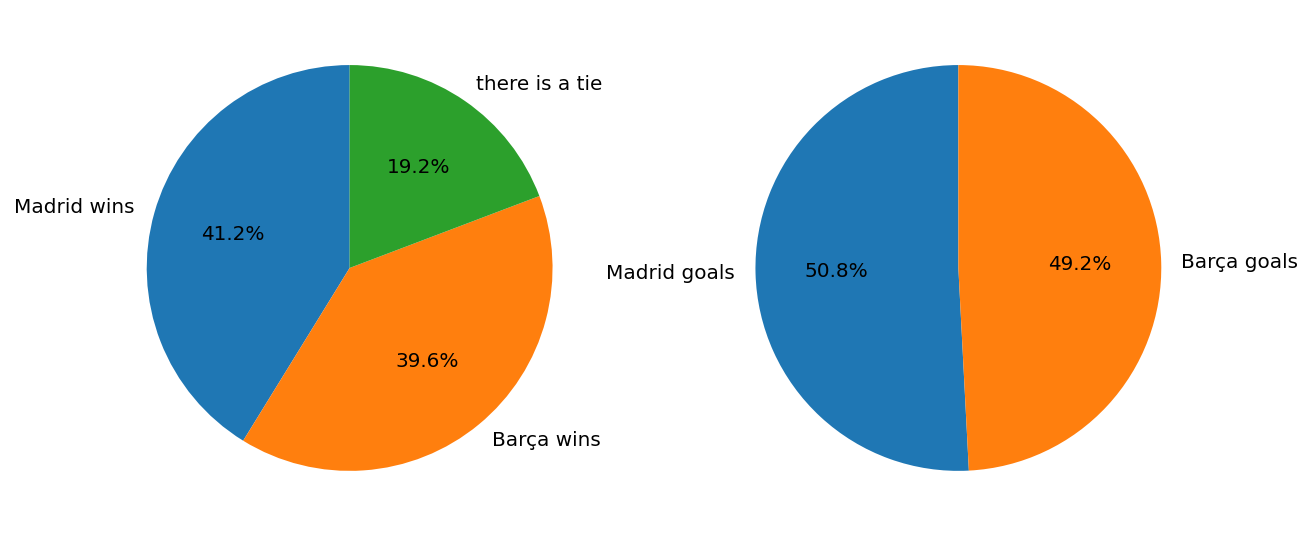

In [12]:
df_home_madrid = df[df['home_team'] == 'Real Madrid'] [df[df['home_team'] == 'Real Madrid'] ['away_team'] == 'Barcelona']
goals_madrid = df_home_madrid['score_home_team'].sum()
df_home_barca = df[df['home_team'] == 'Barcelona'] [df[df['home_team'] == 'Barcelona'] ['away_team'] == 'Real Madrid']
goals_barca = df_home_barca['score_home_team'].sum()

df_bar_vs_mad = pd.concat([df_home_madrid, df_home_barca])

madrid_wins = (df_home_madrid['score_home_team'] > df_home_madrid['score_away_team']).sum() + (df_home_barca['score_home_team'] < df_home_barca['score_away_team']).sum()
barca_wins = (df_home_barca['score_home_team'] > df_home_barca['score_away_team']).sum() + (df_home_madrid['score_home_team'] < df_home_madrid['score_away_team']).sum()
ties = (df_bar_vs_mad['score_home_team'] == df_bar_vs_mad['score_away_team']).sum()

sizes = [madrid_wins, barca_wins, ties]
labels = ['Madrid wins', 'Barça wins', 'there is a tie']

fig = plt.figure(figsize=(10,10),dpi=144)

ax1 = fig.add_subplot(121)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

sizes = [goals_madrid, goals_barca]
labels = ['Madrid goals', 'Barça goals']

ax2 = fig.add_subplot(122)
ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.show()

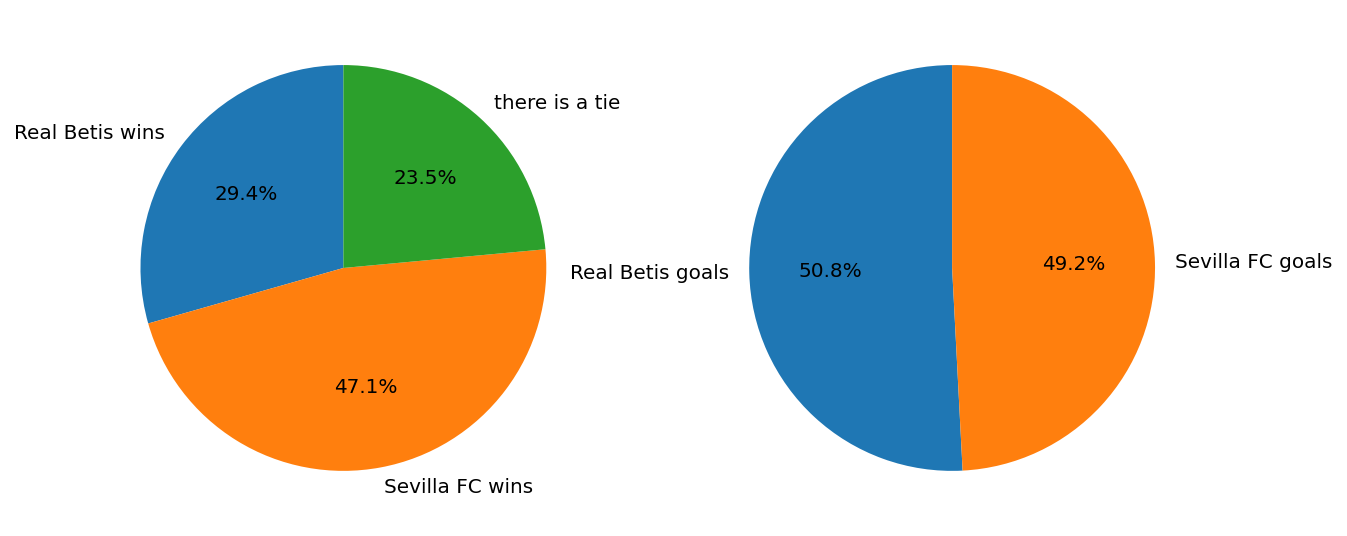

In [13]:
#function exercise 5
def plot_direct_confontations_stats(team1,team2):
    df_home_team1 = df[df['home_team'] == team1] [df[df['home_team'] == team1] ['away_team'] == team2]
    goals_team1 = df_home_team1['score_home_team'].sum()
    df_home_team2 = df[df['home_team'] == team2] [df[df['home_team'] == team2] ['away_team'] == team1]
    goals_team2 = df_home_team2['score_home_team'].sum()

    df_team1_vs_team2 = pd.concat([df_home_team1, df_home_team2])

    team1_wins = (df_home_team1['score_home_team'] > df_home_team1['score_away_team']).sum() + (df_home_team2['score_home_team'] < df_home_team2['score_away_team']).sum()
    team2_wins = (df_home_team2['score_home_team'] > df_home_team2['score_away_team']).sum() + (df_home_team1['score_home_team'] < df_home_team1['score_away_team']).sum()
    ties = (df_team1_vs_team2['score_home_team'] == df_team1_vs_team2['score_away_team']).sum()

    sizes = [team1_wins, team2_wins, ties]
    labels = [team1 + ' wins', team2 + ' wins', 'there is a tie']

    fig = plt.figure(figsize=(10,10),dpi=144)

    ax1 = fig.add_subplot(121)
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

    sizes = [goals_madrid, goals_barca]
    labels = [team1 + ' goals', team2 + ' goals']

    ax2 = fig.add_subplot(122)
    ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.show()

plot_direct_confontations_stats('Real Betis','Sevilla FC')

### Exercise 6

### Exercise 7

In [14]:
df['Winner'] = np.where(df['score_home_team'] > df['score_away_team'],1,np.where(df['score_home_team'] < df['score_away_team'],0,-1))

def func_home_wins(data):
    return (data[data == 1]).count()

def func_away_wins(data):
    return (data[data == 0]).count()

def func_tie(data):
    return (data[data == -1]).count()

df_class_home = df.groupby(['division','season','home_team']).agg(
    GF = pd.NamedAgg(column='score_home_team', aggfunc='sum'),
    GA = pd.NamedAgg(column='score_away_team', aggfunc='sum'),
    W = pd.NamedAgg(column='Winner', aggfunc=func_home_wins),
    L = pd.NamedAgg(column='Winner', aggfunc=func_away_wins),
    T = pd.NamedAgg(column='Winner', aggfunc=func_tie)
    ).reset_index()
df_class_away = df.groupby(['division','season','away_team']).agg(
    GF = pd.NamedAgg(column='score_away_team', aggfunc='sum'),
    GA = pd.NamedAgg(column='score_home_team', aggfunc='sum'),
    W = pd.NamedAgg(column='Winner', aggfunc=func_away_wins),
    L = pd.NamedAgg(column='Winner', aggfunc=func_home_wins),
    T = pd.NamedAgg(column='Winner', aggfunc=func_tie)
    ).reset_index()

df_class_away.rename(columns={'away_team': 'team'}, inplace=True)
df_class_home.rename(columns={'home_team':'team'},inplace=True)

df_classifiaction = df_class_away.merge(df_class_home,how='outer')

df_classifiaction=df_classifiaction.groupby(['season','team','division']).sum().reset_index()


df_classifiaction['GD'] = df_classifiaction['GF'] - df_classifiaction['GA']
df_classifiaction['Pts'] = (df_classifiaction['W']) * 3 + df_classifiaction['T']

df_classifiaction


df_classifiaction['year_of_start']=df_classifiaction['season'].str.split("-").str[0].astype(int)
 


df_classifiaction_ordered = df_classifiaction.sort_values(by=['year_of_start'], ascending=False)

df_classifiaction_ordered=df_classifiaction.sort_values(by=['year_of_start','division'],ascending=[False,True])

df_classifiaction_ordered=df_classifiaction.sort_values(by=['year_of_start','division','Pts'], ascending=[False,True,False])

df_classifiaction_ordered=df_classifiaction.sort_values(by=['year_of_start','division','Pts','GD'],ascending=[False,True,False,False])

df_classifiaction_ordered=df_classifiaction.sort_values(by=['year_of_start','division','Pts','GD','GF'],ascending=[False,True,False,False,False])

df_classifiaction_ordered=df_classifiaction_ordered.reset_index(drop=True)

df_classifiaction_ordered['Rank']=df_classifiaction_ordered.groupby(['year_of_start','division']).cumcount()+1

df_final_classification_ordered=df_classifiaction_ordered.drop(columns=['year_of_start'])

df_final_classification_ordered
df_final_classification_ordered.to_excel('SeasonStandings.xlsx')

### Exercise 8

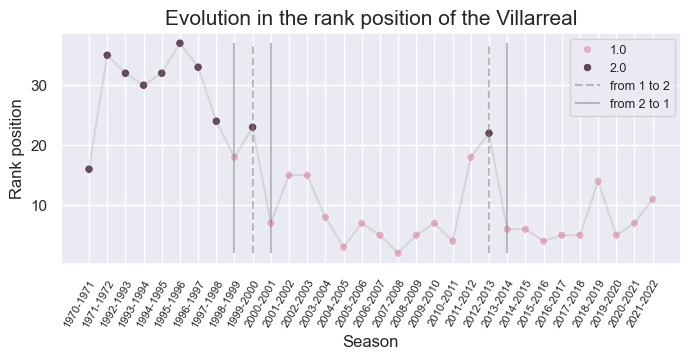

In [188]:
#obtainig the data of 
df_villarreal_1=df_final_classification_ordered[(df_final_classification_ordered['team']=='Villarreal')&(df_final_classification_ordered['division']==1.0)]

#now, we will work with division 2 
#this is for having the data of years in which villarreal is in division 2
df_villarreal_2=df_final_classification_ordered[(df_final_classification_ordered['team']=='Villarreal')&(df_final_classification_ordered['division']==2.0)]
seasons_villarreal_2= df_villarreal_2['season']

#df of all the teams that were in first division when villarreal was in division 2 
df_total_v2=df_final_classification_ordered[(df_final_classification_ordered['season'].isin(seasons_villarreal_2))&df_final_classification_ordered['division']==1.0]
#taking the lowest rank position for each season so we can sum the position in div 2 to it
lowest_rank_div1= df_total_v2.groupby('season')['Rank'].max().reset_index()
df_villarreal_2=df_villarreal_2.merge(lowest_rank_div1,how='outer')
df_villarreal_2_final=df_villarreal_2.groupby(['season']).sum().reset_index()

#joining both df and sorting them out by year (so we can use the data for the plot!!)
df_villarreal= df_villarreal_1.merge(df_villarreal_2_final,how='outer')
df_villarreal['year_start']=df_villarreal['season'].str.split('-').str[0].astype(int)
df_villarreal_ordered=df_villarreal.sort_values(by=['year_start'],ascending=[True])

#I want to know where there are shifts in division!! 
df_villarreal_ordered.reset_index(drop=True, inplace=True)
df_villarreal_ordered['shift']=(df_villarreal_ordered['division']!=df_villarreal_ordered['division'].shift()).astype(int)
df_villarreal_shifts_to_1=df_villarreal_ordered[(df_villarreal_ordered['shift']==1) & (df_villarreal_ordered['division']==2.0)].drop(df_villarreal_ordered.index[0])
df_villarreal_shifts_to_2=df_villarreal_ordered[(df_villarreal_ordered['shift']==1) & (df_villarreal_ordered['division']==1.0)]


#plotting the graphic!!! 
sns.set_theme()
fig=plt.figure(figsize=(8,3))
colors=["#e3b1c8","#63465A"]
sns.scatterplot(data=df_villarreal_ordered,x='season',y='Rank',hue='division',palette=colors)
sns.lineplot(data=df_villarreal_ordered,x='season',y='Rank',color='grey',alpha=0.2)
plt.xticks(rotation=60, ha='right',rotation_mode='anchor', fontsize=8)
plt.xlabel('Season')
plt.ylabel('Rank position')

#lines that show the shifts in division, the dashed ones are when they went to div2 and solids are from the other way around
plt.vlines(x=df_villarreal_shifts_to_1['season'],ymin=df_villarreal_ordered['Rank'].min(),ymax=df_villarreal_ordered['Rank'].max(),label='from 1 to 2', color='grey',alpha=0.5,linestyles='dashed')
plt.vlines(x=df_villarreal_shifts_to_2['season'],ymin=df_villarreal_ordered['Rank'].min(),ymax=df_villarreal_ordered['Rank'].max(),label='from 2 to 1',color="grey",alpha=0.5)
# plt.text(df_villarreal_shifts_to_2['season'].iloc[-1], 10,r'''$\rightarrow$ this is the last shift 
        #  from second division to first''',fontsize=7,color='dimgray')
plt.legend(fontsize=9)
plt.title('Evolution in the rank position of the Villarreal',fontsize=15)
plt.show()



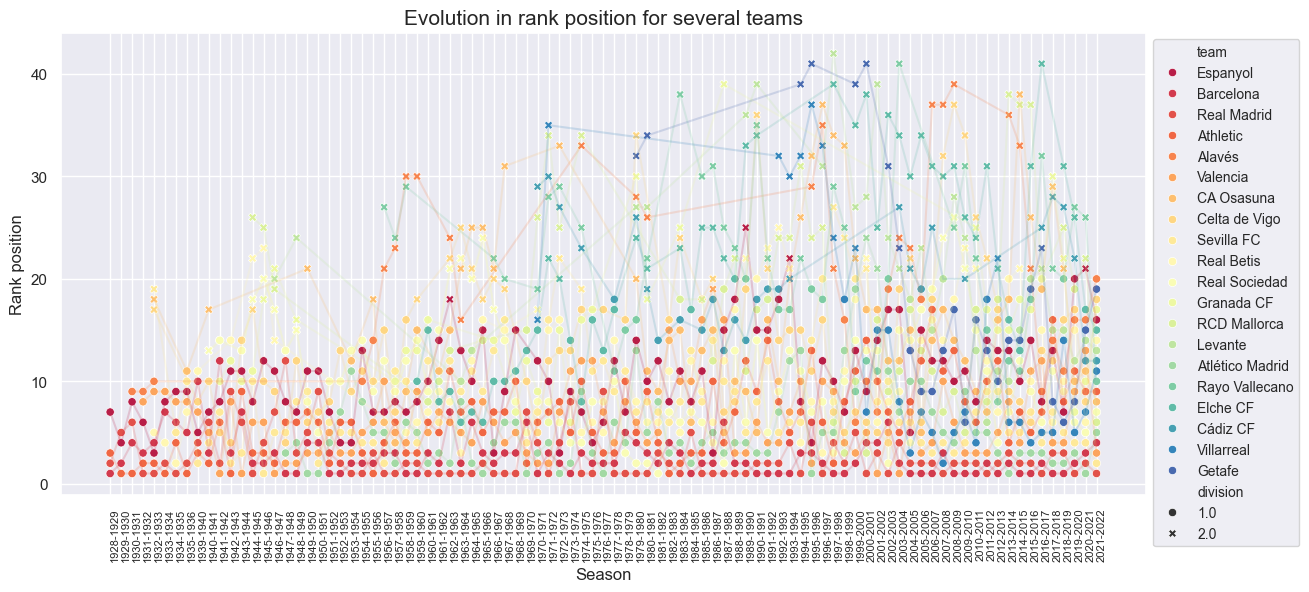

In [189]:
df_plot=pd.DataFrame() #defining an empty df that helps us ataching the data of the funcion into it!!

#function that works in the same way as the code above, but with several teams
def plot_ranking_evolution(*teams):
    global df_plot 
    for team in teams:
        df_current_iter=df_final_classification_ordered[df_final_classification_ordered['team']==team]
        df_plot_div1=df_current_iter[df_current_iter['division']==1.0]
        df_plot_div2=df_current_iter[df_current_iter['division']==2.0]
        seasons_team_div2=df_plot_div2['season']
        df_team_in2=df_final_classification_ordered[df_final_classification_ordered['season'].isin(seasons_team_div2)]
        df_team_in2_div1=df_team_in2[df_team_in2['division']==1.0]
        lowest_rank_div1=df_team_in2_div1.groupby('season')['Rank'].max().reset_index()
        df_plot_div2=df_plot_div2.merge(lowest_rank_div1,how='outer')
        df_plot_div2_final= df_plot_div2.groupby(['season']).sum().reset_index()
        df_team=df_plot_div1.merge( df_plot_div2_final,how='outer')
        df_plot=pd.concat([df_plot,df_team])
    df_plot['year_start']=df_plot['season'].str.split('-').str[0].astype(int)
    df_plot_ordered=df_plot.sort_values(by=['year_start'],ascending=[True])

    sns.set_theme()
    fig=plt.figure(figsize=(14,6))
    sns.lineplot(data=df_plot_ordered,x='season',y='Rank',hue='team',legend=False,palette='Spectral',alpha=0.2)
    sns.scatterplot(data=df_plot_ordered,x='season',y='Rank',hue='team',style='division',markers=True,palette='Spectral')
    plt.xticks(rotation=90, ha='right',rotation_mode='anchor', fontsize=8)
    plt.xlabel('Season')
    plt.ylabel('Rank position')
    plt.legend( bbox_to_anchor=(1, 1), loc='upper left',fontsize=10)
    plt.title('Evolution in rank position for several teams', fontsize=15)

    plt.show()

#for ploting the ranking evolution of several teams, if you want to play with it, remember to use the format ('team',...)!!
plot_ranking_evolution('Real Madrid','Villarreal','Real Sociedad','Sevilla FC','Valencia','Barcelona','Atlético Madrid','RCD Mallorca','Real Sociedad','CA Osasuna', 'Athletic','Rayo Vallecano','Cádiz CF','Levante','Real Betis','Elche CF','Espanyol','Granada CF', 'Celta de Vigo','Getafe','Alavés')







### Exercise 9

### Exercise 10